In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy
import glob, sys

[sys.path.append(f) for f in glob.glob('../utils/*')]
from preprocess import *
from plotting_utils import *
from lineplots import plotsd
from stabilizer_utils import *
from recalibration_utils import *
from session_utils import *

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score


min_nblocks    = 2
max_ndays      = 1e99
participant    = 'T5'


FILE_DIR       = '/oak/stanford/groups/shenoy/ghwilson/nonstationarities/' + participant + '/'
fig_path       = '/home/users/ghwilson/projects/nonstationarities/figures/'
filelist       = glob.glob(FILE_DIR + 'historical/*')
filelist.extend(glob.glob(FILE_DIR + 'new/*'))

block_constraints = getBlockConstraints(FILE_DIR)

files          = get_Sessions(filelist, min_nblocks,  block_constraints = block_constraints)
pairs          = get_SessionPairs(files, max_ndays = max_ndays)
n_pairs        = len(pairs)

In [2]:
def normalizeDecoderGain(lm, decVec, posErr, thresh):
    targDist = np.linalg.norm(posErr, axis = 1)
    targDir  = posErr / targDist[:, np.newaxis]

    farIdx  = np.where(targDist > thresh)[0]

    projVec   = np.sum(np.multiply(decVec[farIdx, :], targDir[farIdx, :]), axis = 1)
    lm.coef_      /= np.mean(projVec)
    lm.intercept_ /= np.mean(projVec)
    
    return lm

def fitLinearModel(y_true, y_pred, threshold):
    
    dists     = np.linalg.norm(y_true, axis = 1)
    dist_mask = dists > threshold
    
    bias = y_pred[dist_mask, :].mean(axis = 0)
    
    y = (y_pred - bias)[dist_mask, :].flatten()
    x = (y_true[dist_mask, :] / dists[dist_mask, None]).flatten() 
    
    scale = x.dot(y) / np.sum(x**2) # normal equation reduces to this
    
    return scale, bias


def estimateNormalizedBias(decoder, x, y, threshold = 300, empirical_correction = True):
    scale, bias    = fitLinearModel(y, decoder.predict(x), threshold)
    
    if empirical_correction:
        bias -= y.mean(axis = 0)
        
    bias_index     = np.linalg.norm(bias) / scale
    
    return bias_index


def estimateSubspaceDrift(ref_coefs, new_coefs):
    '''Inputs are:
        
        ref_coefs (2D array) - n_vars x nChannels array of encoding/decoding weights
        new_coefs (2D array) - same as above '''
    
    assert ref_coefs.shape == new_coefs.shape, 'inputs must be same size'
        
    angles = list()
    
    for i in range(ref_coefs.shape[0]):
        drift_angle = angle_between(ref_coefs[i, :], new_coefs[i, :])
        angles.append(drift_angle)
        
    overall_angle = angle_between(ref_coefs.flatten(), new_coefs.flatten())
        
    return angles, overall_angle
    
    

def plotAngleDifferences(x, angles, colors, labels = None, alpha = None):
    '''Plot angular differences across time. Inputs are:
    
        x (1D float array)    - nSamples of x-axis values 
        angles (2D float)     - nSamples x nClasses of angles 
        colors (1D str array) - nClasses of colors 
        labels (1D str array) - nClasses of labels
        
    '''
    
    nClasses = angles.shape[1]
    
    if labels == None:
        labels = [None] * nClasses
    
    for i in range(nClasses):
        y = angles[:, i]
 
        plt.scatter(x, y, alpha = alpha, color = colors[i], label = labels[i])

        #poly = np.poly1d(np.polyfit(x, y, deg = 2))
        #plt.plot(np.arange(max(x)), poly(np.arange(max(x))), color = colors[i])

        #bootstrap_CI = np.zeros((len(np.arange(max(x))), n_iters))
        #for j in range(n_iters):
        #    bs_inds = np.random.choice(len(x), len(x), replace = True)
        #    poly    = np.poly1d(np.polyfit(x[bs_inds], y[bs_inds], deg = 2))
        #    bootstrap_CI[:, j] = poly(np.arange(max(x)))

        #plotsd(bootstrap_CI.T, time_bins= np.arange(max(x)), color = colors[i])

    plt.ylabel('Tuning similarity (Cos $\theta$)')
    plt.axhline(0, c = 'k', linestyle = '--')
    plt.ylim([-1, 1])
    plt.legend()

In [5]:
from joblib import Parallel, delayed
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
import warnings


def search_regularization(reg_opts, x_train, y_train):
    
    tuned_params = {'alpha' : reg_opts}
    clf          = GridSearchCV(Ridge(), tuned_params).fit(x_train, y_train)
    
    return clf.best_estimator_


def processSingleSession(file, cfg):
    
 
    session_dict = dict()
    fields       = ['TX', 'cursorPos', 'targetPos']
    
    # First calculate encoding and decoding weights independently for each session:
    session = DataStruct(file, causal_filter = cfg['sigma'], alignScreens = True)
    blocks  = block_constraints[file]

    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = cfg['train_size'], 
                               task = cfg['task'], blocks = blocks, returnFlattened = True)    
    train_y     = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y      = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])

    reference_means = session_dat['test_TX'][-1].mean(axis = 0)
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'],
                                    method = 'blockwise', concatenate = True)

    # train encoders and decoders
    #decoder         = Ridge(alpha = reg_strength, normalize = False).fit(train_x, train_y)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        decoder      = search_regularization(cfg['reg_opts'], train_x, train_y)
        test_decoder = search_regularization(cfg['reg_opts'], test_x, test_y)
        score        = decoder.score(test_x, test_y)

    encoder         = fitEncodingMatrix(train_y, train_x, fitMean = False)[0]
    test_encoder    = fitEncodingMatrix(test_y, test_x, fitMean = False)[0]

    # measure within-session bias changes:
    bias_index_test  = estimateNormalizedBias(decoder, test_x, test_y, threshold = 300)
    bias_index_train = estimateNormalizedBias(decoder, train_x, train_y, threshold = 300)
    session_dict['normalized_bias_index']         = bias_index_test
    session_dict['normalized_bias_index_control'] = bias_index_train

    # measure within-session PD changes:
    encoder_angles, encoder_overall = estimateSubspaceDrift(encoder[1:, :], 
                                                            test_encoder[1:, :])
    decoder_angles, decoder_overall = estimateSubspaceDrift(decoder.coef_, 
                                                            test_decoder.coef_)

    session_dict['encoder angles'] = encoder_angles
    session_dict['decoder angles'] = decoder_angles
    session_dict['combined decoder angle'] = decoder_overall

    session_dict['dates']         = deepcopy(session.date)
    session_dict['decoder_means'] = reference_means
    session_dict['scores']   = score
    session_dict['encoders'] = encoder
    session_dict['decoders'] = decoder
    
    return session_dict

In [6]:
# general settings:
np.random.seed(42)
cfg = dict()

cfg['task']         = None
cfg['train_size']   = 0.5
cfg['sigma']        = 2
cfg['reg_opts']     = [1e1, 1e3, 1e5, 1e7, 1e9]

# --------------------------------------------------
uniqueFiles     = np.unique(np.concatenate(pairs))

dict_list   = Parallel(n_jobs=-1, verbose = 5)(delayed(processSingleSession)(file, cfg) for file in uniqueFiles)

session_dict = dict()
for key in dict_list[0].keys():
    session_dict[key] = list()
    for d in dict_list:
        session_dict[key].append(d[key])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  49 | elapsed:   39.5s remaining:    8.9s


NameError: name 'fitEncodingMatrix' is not defined

In [ ]:
figSize(12, 18)

best_idx  = np.argmin(session_dict['normalized_bias_index_control'])
worst_idx = np.argmax(session_dict['normalized_bias_index_control'])
labels    = ['Best index', 'Worst index']

for i, idx in enumerate([best_idx, worst_idx]):
    file    = uniqueFiles[idx]
    session = DataStruct(file, causal_filter = sigma, alignScreens = True)
    blocks  = block_constraints[file]
    
    # obtain features and cursorError targets:
    session_dat = getTrainTest(session, fields = fields, train_size = train_size, 
                               task = task, blocks = blocks, returnFlattened = True)    
    train_y     = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y      = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])
    
    # 
    reference_means = session_dat['test_TX'][-1].mean(axis = 0)
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'],
                                    method = 'blockwise', concatenate = True)
    decoder         = Ridge(alpha = 1e7, normalize = False).fit(train_x, train_y)
    encoder         = fitEncodingMatrix(train_y, train_x, fitMean = False)[0]
    score           = decoder.score(test_x, test_y)
    
    scale, bias    = fitLinearModel(train_y, decoder.predict(train_x), threshold = 300)
    
    plt.subplot(2, 2, i + 1)
    
    plt.imshow(train_x.T, aspect = 'auto')
    plt.title(labels[i] + ': ' + session.date)
    plt.xlabel('Time')
    plt.ylabel('Channels')
    
    plt.subplot(2, 2, i + 1 + 2)
    window = np.arange(2000, 5000) + 3000
    offset = np.asarray([0, 400])
    plt.plot(train_y[window] + offset, color = 'k')
    plt.plot(decoder.predict(train_x[window]) + offset)
    plt.title('R2 = {:.3f}, scale = {:.3f}, bias = {:.3f}'.format(score, scale, np.linalg.norm(bias)))

plt.show()


In [ ]:
def generatePairData(A_file, B_file):
    
    dict_fields = ['reference date', 'new date', 'days apart', 'encoder angles', 'decoder angles', 'combined decoder angle', 
               'full recal score', 'meanrecal score', 'norecal score', 'normalized_bias_index']
    scores_dict = dict()
    
    for key in dict_fields:
        scores_dict[key] = list()
    
        
    # metadata 
    A_date   = A_file.split('t5.')[1].split('.mat')[0]
    B_date   = B_file.split('t5.')[1].split('.mat')[0]

    scores_dict['reference date'].append(A_date)
    scores_dict['new date'].append(B_date)
    scores_dict['days apart'].append(daysBetween(A_date, B_date))

    A_ind  = np.where(np.in1d(session_dict['dates'], A_date))[0][0]
    B_ind  = np.where(np.in1d(session_dict['dates'], B_date))[0][0]

    # angular drift metrics
    
    encoder_angles, encoder_overall = estimateSubspaceDrift(session_dict['encoders'][A_ind][1:, :], 
                                                            session_dict['encoders'][B_ind][1:, :])
    
    decoder_angles, decoder_overall = estimateSubspaceDrift(session_dict['decoders'][A_ind].coef_, 
                                                            session_dict['decoders'][B_ind].coef_)
    
    scores_dict['encoder angles'].append(encoder_angles)
    scores_dict['decoder angles'].append(decoder_angles)
    scores_dict['combined decoder angle'].append(decoder_overall)


    # functional metrics - offline R^2  
    scores_dict['full recal score'].append(session_dict['scores'][B_ind])

    session = DataStruct(B_file, causal_filter = sigma, alignScreens = True)

    # obtain features and cursorError targets:
    session_dat     = getTrainTest(session, fields = fields, train_size = train_size, task = task, returnFlattened = True)    
    train_y         = np.concatenate(session_dat['train_targetPos']) - np.concatenate(session_dat['train_cursorPos'])
    test_y          = np.concatenate(session_dat['test_targetPos']) - np.concatenate(session_dat['test_cursorPos'])

    # 
    train_x, test_x = subtractMeans(session_dat['train_TX'], session_dat['test_TX'], 
                                    method = 'blockwise', concatenate = True)
    meanrecal_score = session_dict['decoders'][A_ind].score(test_x, test_y)
    scores_dict['meanrecal score'].append(meanrecal_score)  

    # 
    test_x  = np.concatenate(session_dat['test_TX']) - session_dict['decoder_means'][A_ind][None, :]

    norecal_score = session_dict['decoders'][A_ind].score(test_x, test_y) 
    scores_dict['norecal score'].append(norecal_score)

    bias_index  = estimateNormalizedBias(session_dict['decoders'][A_ind], test_x, test_y, threshold = 300)
    scores_dict['normalized_bias_index'].append(bias_index)
    
    return scores_dict


In [ ]:
from joblib import Parallel, delayed
import pandas as pd


dict_list   = Parallel(n_jobs=-1, verbose = 1)(delayed(generatePairData)(*arg) for arg in pairs)
scores_dict = pd.DataFrame(dict_list).to_dict()

for key, value in scores_dict.items():
    scores_dict[key] = np.concatenate(list(value.values()))

In [ ]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.cm as cm

# define colormap based on R2 value
norm = mpl.colors.Normalize(vmin=0, vmax=0.5)
cmap = cm.plasma
m    = cm.ScalarMappable(norm=norm, cmap= cmap)

# optionally subselect points 
#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

figSize(20, 15)

plt.subplot(4, 1, 1)
sns.scatterplot(x = np.log10(scores_dict['days apart']), y = scores_dict['full recal score'])
sns.scatterplot(x = np.log10(scores_dict['days apart']), y = scores_dict['meanrecal score'])
plt.legend(['Mean recal', 'Full recal'])
plt.title('Mean recalibration versus full recalibration')
plt.xlabel('Days (log10)')
plt.ylabel('R^2 score')

plt.subplot(4, 1, 2)
y = np.asarray(scores_dict['meanrecal score']) / np.asarray(scores_dict['full recal score'])

sns.scatterplot(x = np.log10(scores_dict['days apart']), y = y)
plt.ylim([-1.05, 1.05])
plt.title('Relative mean recalibration performance (normalized by within-day performance)')
plt.xlabel('Days (log10)')
plt.ylabel('Relative R^2')
ax = plt.gca()
ax.tick_params(direction = 'in')

# PD shift across time
plt.subplot(4, 1, 3)

alpha     = 0.5

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])
y     = np.cos(np.vstack(scores_dict['combined decoder angle'])[subselect, :][sort_idx])
colors = [m.to_rgba(np.asarray(scores_dict['meanrecal score'])[subselect][sort_idx])]

plotAngleDifferences(x, y, colors, None, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')
plt.colorbar(m)
ax = plt.gca()
ax.tick_params(direction = 'in')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

y_session = np.asarray(session_dict['combined decoder angle'])
y_session = y_session[y_session > 0]
x_session = np.random.normal(-0.5, 0.05, y_session.shape)
colors = m.to_rgba(session_dict['scores'])

plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session')


# Bias across time
plt.subplot(4, 1, 4)
y = np.asarray(scores_dict['normalized_bias_index'])[subselect][sort_idx][:, None]
x = np.asarray(scores_dict['days apart'])[subselect][sort_idx]
x = np.log10(x)
colors = [m.to_rgba(np.asarray(scores_dict['norecal score'])[subselect][sort_idx])]

plotAngleDifferences(x, y, colors, ['Across session'], alpha)

y_session = np.asarray(session_dict['normalized_bias_index'])
y_session = y_session[y_session > 0]
x_session = np.random.normal(-0.5, 0.05, y_session.shape)
colors = m.to_rgba(session_dict['scores'])

plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session')

y_session = np.asarray(session_dict['normalized_bias_index_control'])
y_session = y_session[y_session > 0]
x_session = np.random.normal(-1.5, 0.05, y_session.shape)
colors = m.to_rgba(session_dict['scores'])

plt.scatter(x_session, y_session, c = colors, alpha = 0.3, label = 'Within session (control)')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_yscale('linear')
ax.set_xscale('linear')
ax.tick_params(direction = 'in')

plt.ylim([-0.001, 10])
plt.xlabel('Number of days apart (log difference)')
plt.ylabel('Normalized bias index')
plt.legend()
plt.title('Bias across time', fontweight = 'bold')
plt.colorbar(m)

plt.tight_layout()
#plt.savefig(fig_path + 'SNR/T5_EncDec_Drift_new_new', format = 'pdf')
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

df = dict()
df['scores'] = session_dict['scores']
df['normalized_bias_index'] = session_dict['normalized_bias_index']
df['combined_decoder_angle'] = session_dict['combined decoder angle']

df = pd.DataFrame(df)

#perform two-way ANOVA
model = ols('scores ~ normalized_bias_index + combined_decoder_angle + normalized_bias_index:combined_decoder_angle', data=df).fit()
sm.stats.anova_lm(model, typ=2)


In [ ]:
figSize(5, 10)

plt.subplot(1, 2, 1)
plt.scatter(session_dict['normalized_bias_index'], session_dict['scores'])
plt.xlabel('Bias index')
plt.ylabel('R^2')

plt.subplot(1, 2, 2)
plt.scatter(session_dict['combined decoder angle'], session_dict['scores'])
plt.show()

In [ ]:
print('-------- Within-session ---------')

mean = np.mean(session_dict['normalized_bias_index_control'])
SD   = np.std(session_dict['normalized_bias_index_control'])

print('Normalized bias index (control): {:.3f} +- {:.3f}'.format(mean, SD))

mean = np.mean(session_dict['normalized_bias_index'])
SD   = np.std(session_dict['normalized_bias_index'])

print('Normalized bias index (test): {:.3f} +- {:.3f}'.format(mean, SD))

bias_diffs = np.asarray(session_dict['normalized_bias_index']) - np.asarray(session_dict['normalized_bias_index_control'])
print('Wilcoxon test of differences: p = {:.3E}'.format(scipy.stats.wilcoxon(bias_diffs)[1]))




figSize(5, 5)
y_session = np.asarray(session_dict['normalized_bias_index'])
y_session = y_session[y_session > 0]
x_session = np.random.normal(-0.5, 0.05, y_session.shape)
colors = m.to_rgba(session_dict['scores'])

plt.scatter(session_dict['normalized_bias_index_control'], session_dict['normalized_bias_index'], c = colors, alpha = 0.5)
plt.xlabel('Training bias')
plt.ylabel('Test bias')
ax = plt.gca()
ax.tick_params(direction = 'in')

#plt.savefig(fig_path + 'SNR/T5_bias_withinsession_comparison', format = 'pdf')
plt.show()

In [ ]:

figSize(15, 12)
weights = np.vstack([x.coef_.flatten() for x in session_dict['decoders']])
corrmap = np.corrcoef(weights)


f, (a0, a1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]})

a0.imshow(corrmap, aspect = 'auto', vmin = 0, vmax = 0.6)
#plt.clim([0, 0.6])
plt.yticks(np.arange(len(session_dict['dates'])), session_dict['dates'], rotation = 0)
#plt.savefig(fig_path + 'SNR/T5_decoder_overlap_matrix', format = 'pdf')

a1.plot(session_dict['scores'])
plt.xticks(np.arange(len(session_dict['scores'])), session_dict['dates'], rotation = 90)

plt.tight_layout()
plt.show()

In [ ]:
PDs = np.vstack([np.arctan2(enc[2, :], enc[1, :]) for enc in session_dict['encoders']])
snr = np.vstack([np.linalg.norm(enc[1:, :], axis = 0) for enc in session_dict['encoders']])


norm = mpl.colors.Normalize(vmin=-3.1, vmax=3.1)
cmap = cm.hsv
m    = cm.ScalarMappable(norm=norm, cmap= cmap)

colors = m.to_rgba(PDs)
colors[:, :, 3] = snr / 90

In [ ]:
figSize(20, 10)

for chan in range(192):
    plt.scatter(np.arange(PDs.shape[0]), np.zeros(PDs.shape[0]) + chan, c = colors[:, chan, :])
    
plt.show()

In [317]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3).fit(weights)
pc_coords = pca.fit_transform(weights)

In [318]:
pca.explained_variance_ratio_

array([0.11196127, 0.06728173, 0.06210957])

In [319]:
days_since_start = [daysBetween(x, session_dict['dates'][0]) for x in (session_dict['dates'])]


norm = mpl.colors.Normalize(vmin=0, vmax = 200 + np.max(days_since_start))
cmap = cm.hot
m    = cm.ScalarMappable(norm=norm, cmap= cmap)


c = m.to_rgba(days_since_start)

In [320]:
from scipy.ndimage import gaussian_filter1d

smoothed_traj = gaussian_filter1d(pc_coords, sigma = 1, axis = 0)

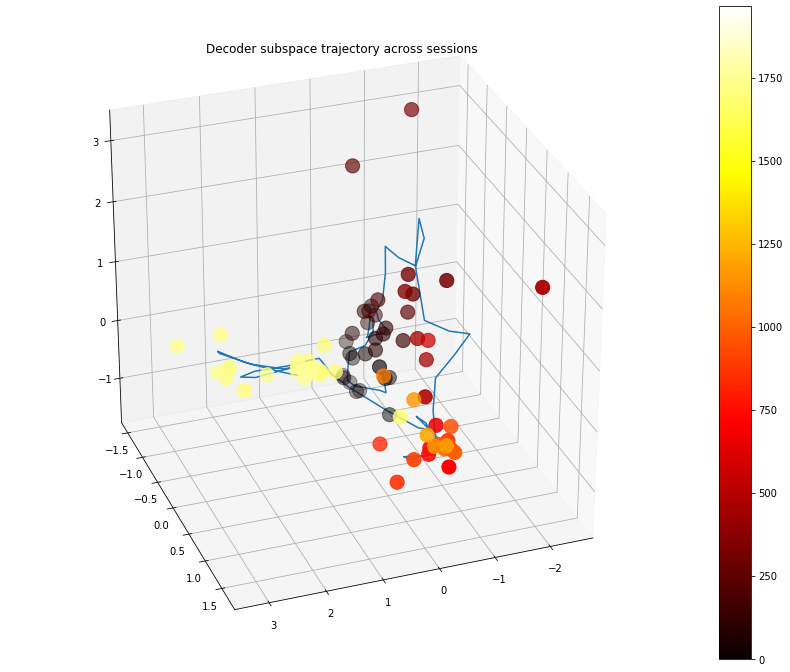

In [321]:
figSize(12, 15)
fig = plt.figure()
ax  = fig.add_subplot(projection='3d')
ax.scatter(pc_coords[:, 0], pc_coords[:, 1], pc_coords[:, 2], c = c, s = 200)
ax.plot3D(smoothed_traj[:, 0], smoothed_traj[:, 1], smoothed_traj[:, 2])
ax.view_init(30, 70)
plt.title('Decoder subspace trajectory across sessions')
plt.colorbar(m)
plt.show()

print()

In [322]:
figSize(5, 10)

colors    = ['b', 'orange']
labels    = ['X velocity', 'Y velocity']
alpha     = 0.5

#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])
y_vals   = np.cos(angles[subselect, :, :])[sort_idx, :, :]


y = np.cos(np.vstack(scores_dict['decoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')

plt.show()

IndexError: index 2628 is out of bounds for axis 0 with size 2628

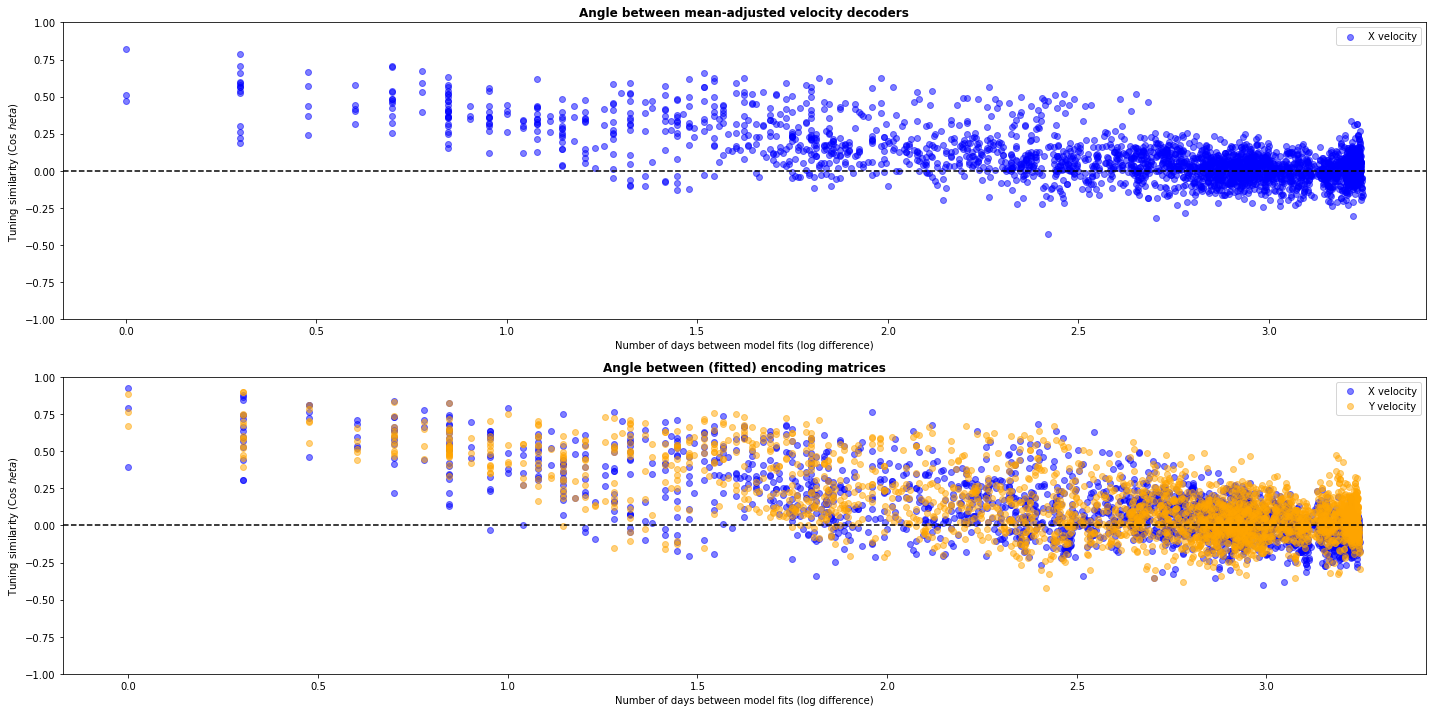

In [195]:
from scipy.signal import savgol_filter

figSize(10, 20)

n_iters   = 1000
colors    = ['b', 'orange']
labels    = ['X velocity', 'Y velocity']
alpha     = 0.5

#subselect = np.logical_and(scores[:, 0] > 0, scores[:, 1] > 0)
#scores    = np.asarray(scores)
#subselect = np.arange(scores.shape[0])
subselect = np.arange(n_pairs)

x         = np.asarray(scores_dict['days apart'])[subselect]
sort_idx  = np.argsort(x)
x         = np.log10(x[sort_idx])
y_vals   = np.cos(angles[subselect, :, :])[sort_idx, :, :]


# Decoders
plt.subplot(2, 1, 1)

y = np.cos(np.vstack(scores_dict['decoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between mean-adjusted velocity decoders', fontweight = 'bold')


# Encodings:
plt.subplot(2, 1, 2)

y = np.cos(np.vstack(scores_dict['encoder angles'])[subselect, :][sort_idx, :])

plotAngleDifferences(x, y, colors, labels, alpha)
plt.xlabel('Number of days between model fits (log difference)')
plt.title('Angle between (fitted) encoding matrices', fontweight = 'bold')


plt.tight_layout()
#plt.savefig(fig_path + 'SNR/T5_EncDec_Drift', format = 'pdf')
plt.show()


### Look at encoder drift model

Now we'll fit a linear model of our encoder drift across days with the formula:

$E' = \alpha E + \epsilon \ \ \ $     where $\epsilon \sim N(0, \sigma^{2}) $

This will help us determine plausible parameters for the closed-loop simulator by figuring out good values for the *shrinkage factor* $\alpha$ and noise model. Once we get the shrinkage factors for each pair of sessions, we can then fit some 
canonical shrinkage factor per day that helps compare these data across pairs (each pair may have e.g. 2 or 200 days apart). In this updated model, we have that:

$E^{(n)} = a^{n} E_{0} + \epsilon \ \ \ $ where $\epsilon \sim N(0, \sigma^{2} n * (\alpha^{n-1})^{2}) $

We can get this base shrinkage $\alpha$ value by performing linear regression on the observed shrinkages in log-space:

$\alpha_{x} \approx \hat{\alpha} = \exp(c \cdot x )$

$c = argmin_{a_{0}} ||\log(\alpha_{x}) - x * log(\alpha_{0}) ||^{2} $

Base alpha =  0.9127546639283498
Base alpha =  0.9250748939988905


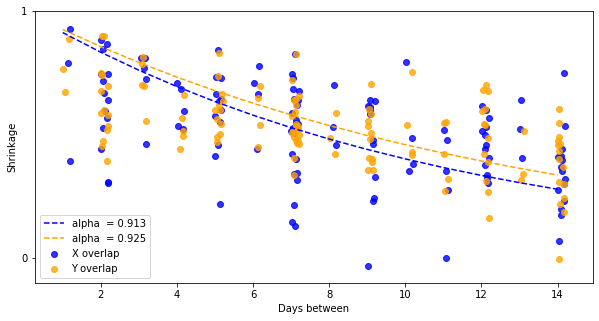

In [196]:
def fitDecayModel(x, y):
    
    pos_mask = y > 0
        
    x_filt = x[pos_mask][:, np.newaxis]
    y_filt = y[pos_mask][:, np.newaxis]
    
    mult  = np.linalg.lstsq(x_filt, np.log(y_filt), rcond = None)[0][0][0]
    alpha = np.exp(mult)
    
    return alpha

figSize(5, 10)
window = 14 # look at sessions up to two weeks apart
colors = ['b', 'orange']
labels = ['X overlap', 'Y overlap']


withinWindow      = np.where(scores_dict['days apart'] <= window)[0]
withinDiffs       = scores_dict['days apart'][withinWindow]

for i in range(2):
    withinShrinkages  = np.cos(scores_dict['encoder angles'][withinWindow, i])
    alpha  = fitDecayModel(withinDiffs, withinShrinkages) 
    print('Base alpha = ', alpha)
    
    x = np.arange(1, max(withinDiffs) + 1)
    y = alpha**x
    plt.scatter(withinDiffs + (0.2 * np.random.rand(*withinDiffs.shape)), withinShrinkages, alpha = 0.8, color = colors[i], label = labels[i])
    plt.plot(x, y, color = colors[i], linestyle = '--', label = 'alpha  = ' + str(np.round(alpha, 3)))

plt.ylim([-0.1, 1])
plt.yticks([0, 1])
plt.xlabel('Days between')
plt.ylabel('Shrinkage')
plt.legend()
#plt.savefig(fig_path + 'SNR/T5_Enc_drift_twoweeks', format = 'pdf')
plt.show()